In [70]:
# pip install catboost

In [71]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, explained_variance_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [3]:
data = pd.read_csv('/Users/raznoglazova.julia/Desktop/project/my_project/VehicleInsuranceData.csv', sep= ',')
data = data.drop(columns=['Unnamed: 0'])

In [4]:
pd.set_option('display.max_columns', 100)
data.head()

,clv,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location.Code,Marital.Status,Monthly.Premium.Auto,Months.Since.Last.Claim,Months.Since.Policy.Inception,Number.of.Open.Complaints,Number.of.Policies,Policy.Type,Policy,Renew.Offer.Type,Sales.Channel,Total.Claim.Amount,Vehicle.Class,Vehicle.Size
0,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,12887.431650,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,7645.861827,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,2813.692575,No,Basic,Bachelor,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [5]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'clv': 'ltv'})
data.columns

Index(['ltv', 'response', 'coverage', 'education', 'employmentstatus',
       'gender', 'income', 'location.code', 'marital.status',
       'monthly.premium.auto', 'months.since.last.claim',
       'months.since.policy.inception', 'number.of.open.complaints',
       'number.of.policies', 'policy.type', 'policy', 'renew.offer.type',
       'sales.channel', 'total.claim.amount', 'vehicle.class', 'vehicle.size'],
      dtype='object')

In [6]:
data['coverage'].value_counts()

Basic       5314
Extended    2563
Premium      753
Name: coverage, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8630 entries, 0 to 8629
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ltv                            8630 non-null   float64
 1   response                       8630 non-null   object 
 2   coverage                       8630 non-null   object 
 3   education                      8630 non-null   object 
 4   employmentstatus               8630 non-null   object 
 5   gender                         8630 non-null   object 
 6   income                         8630 non-null   int64  
 7   location.code                  8630 non-null   object 
 8   marital.status                 8630 non-null   object 
 9   monthly.premium.auto           8630 non-null   int64  
 10  months.since.last.claim        8630 non-null   int64  
 11  months.since.policy.inception  8630 non-null   int64  
 12  number.of.open.complaints      8630 non-null   i

In [8]:
data.describe()

,ltv,income,monthly.premium.auto,months.since.last.claim,months.since.policy.inception,number.of.open.complaints,number.of.policies,total.claim.amount
count,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000
mean,6725.281515,37586.405794,91.677057,15.084473,48.004287,0.389108,3.020626,427.131607
std,3934.876313,30453.838594,32.648209,10.048979,27.880693,0.920491,2.445994,282.722326
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3858.177183,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,268.881398
50%,5569.220419,33817.000000,81.000000,14.000000,48.000000,0.000000,2.000000,376.880363
75%,8456.408530,62250.750000,108.000000,23.000000,71.000000,0.000000,4.000000,542.400000
max,21235.445570,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


<Axes: ylabel='ltv'>

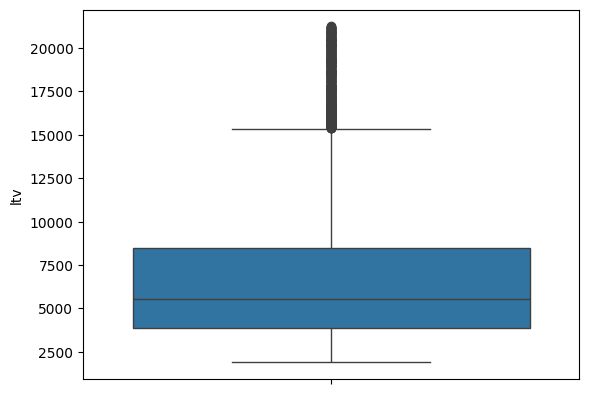

In [9]:
sns.boxplot(data.ltv)

<Axes: ylabel='ltv'>

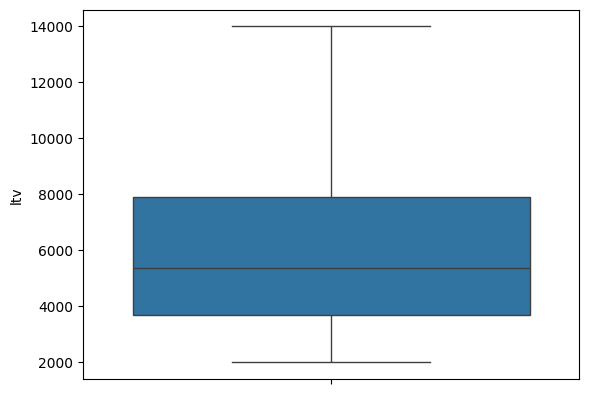

In [10]:
# Clear outliers
data = data[(data.ltv>2000) & (data.ltv < 14000)]    
sns.boxplot(data.ltv)

In [11]:
encoder = preprocessing.LabelEncoder()

for i in data.columns:
    if isinstance(data[i][0], str):
            data[i] = encoder.fit_transform(data[i])

In [12]:
data.head()

,ltv,response,coverage,education,employmentstatus,gender,income,location.code,marital.status,monthly.premium.auto,months.since.last.claim,months.since.policy.inception,number.of.open.complaints,number.of.policies,policy.type,policy,renew.offer.type,sales.channel,total.claim.amount,vehicle.class,vehicle.size
0,2763.519279,0,0,0,1,0,56274,1,1,69,32,5,0,1,0,2,0,0,384.811147,5,1
1,6979.535903,0,1,0,4,0,0,1,2,94,13,42,0,8,1,5,2,0,1131.464935,0,1
2,12887.431650,0,2,0,1,0,48767,1,1,108,18,38,0,2,1,5,0,0,566.472247,5,1
3,7645.861827,0,0,0,4,1,0,1,1,106,18,65,0,7,0,1,0,2,529.881344,3,1
4,2813.692575,0,0,0,1,1,43836,0,2,73,12,44,0,1,1,3,0,0,138.130879,0,1


In [13]:
shapiro(data.gender)

ShapiroResult(statistic=0.6365571081146748, pvalue=1.4469334285832443e-84)

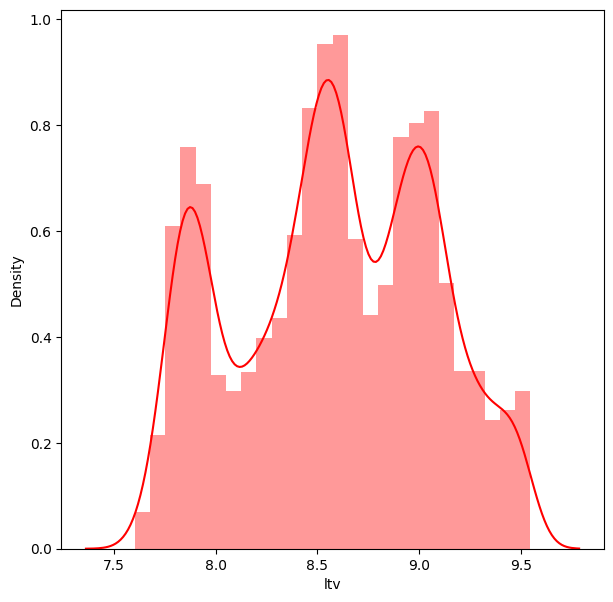

In [14]:
fig = plt.figure
fig,ax= plt.subplots(figsize=(7,7))
sns.distplot(data.ltv.apply(np.log),color='red',label='ltv',ax=ax)
# sns.distplot(data['total.claim.amount'].apply(np.log),color='blue',label='total.claim.amount',ax=ax)
plt.show()

In [15]:
# select features based on VIF and correlation coefficients
correlations_data = data.corr()['ltv'].sort_values()
correlations_data[((correlations_data > 0.1) | (correlations_data < -0.1)) & (correlations_data < 1.0)]

renew.offer.type       -0.125073
vehicle.class           0.108039
total.claim.amount      0.223171
coverage                0.250376
number.of.policies      0.293738
monthly.premium.auto    0.428807
Name: ltv, dtype: float64

In [16]:
pearsonr(data.ltv.apply(np.log), data['monthly.premium.auto'].apply(np.log))

PearsonRResult(statistic=0.4563139083789207, pvalue=0.0)

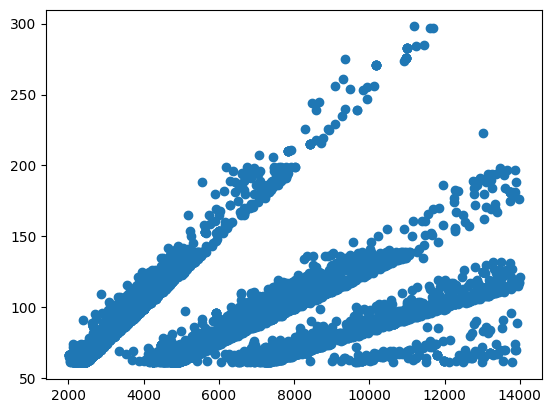

In [17]:
plt.scatter(data.ltv, data['monthly.premium.auto'])

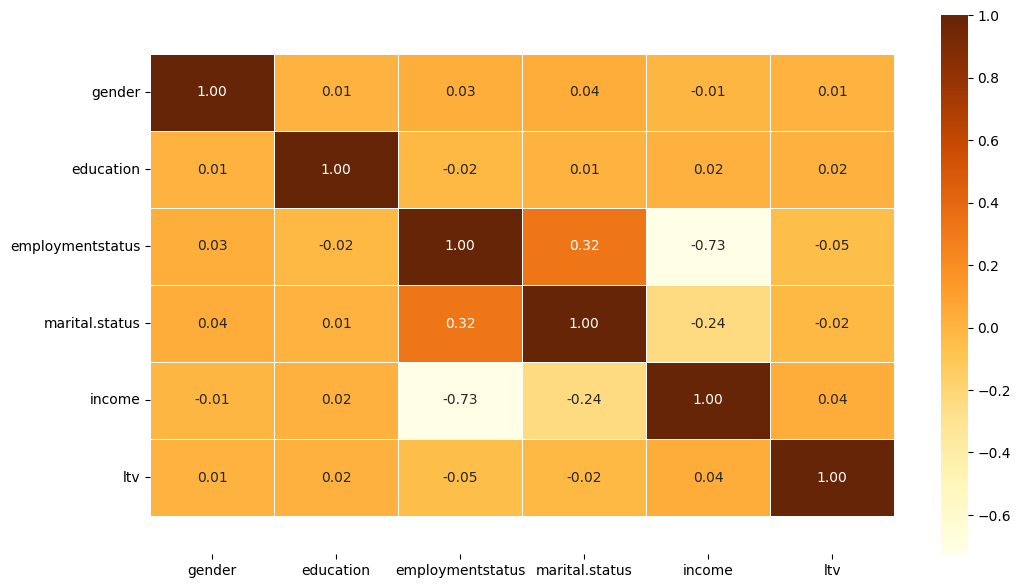

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap(data[['gender','education','employmentstatus','marital.status','income','ltv']].corr(),annot=True,linewidths=0.5,fmt=".2f",cmap='YlOrBr')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig("client_correlation.png")

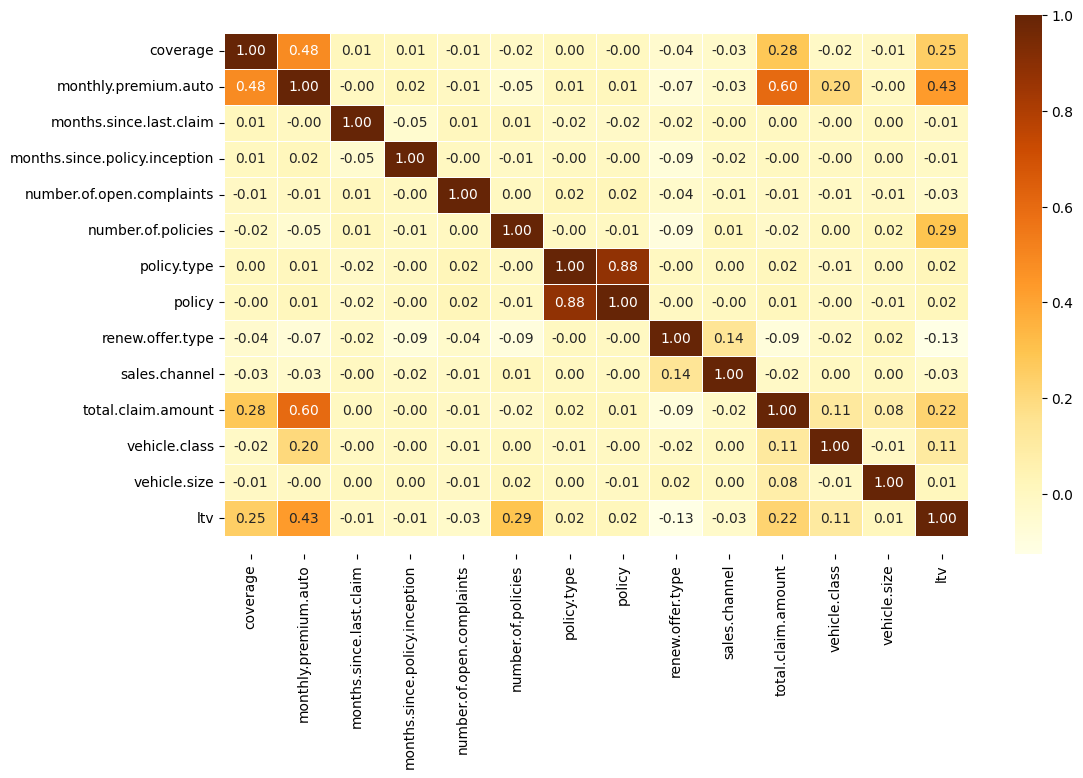

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap(data[['coverage','monthly.premium.auto', 'months.since.last.claim','months.since.policy.inception', 'number.of.open.complaints','number.of.policies', 'policy.type', 'policy',\
            'renew.offer.type','sales.channel', 'total.claim.amount', 'vehicle.class', 'vehicle.size','ltv']].corr(),annot=True,linewidths=0.5,fmt=".2f",cmap='YlOrBr')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

plt.savefig("product_correlation.png")

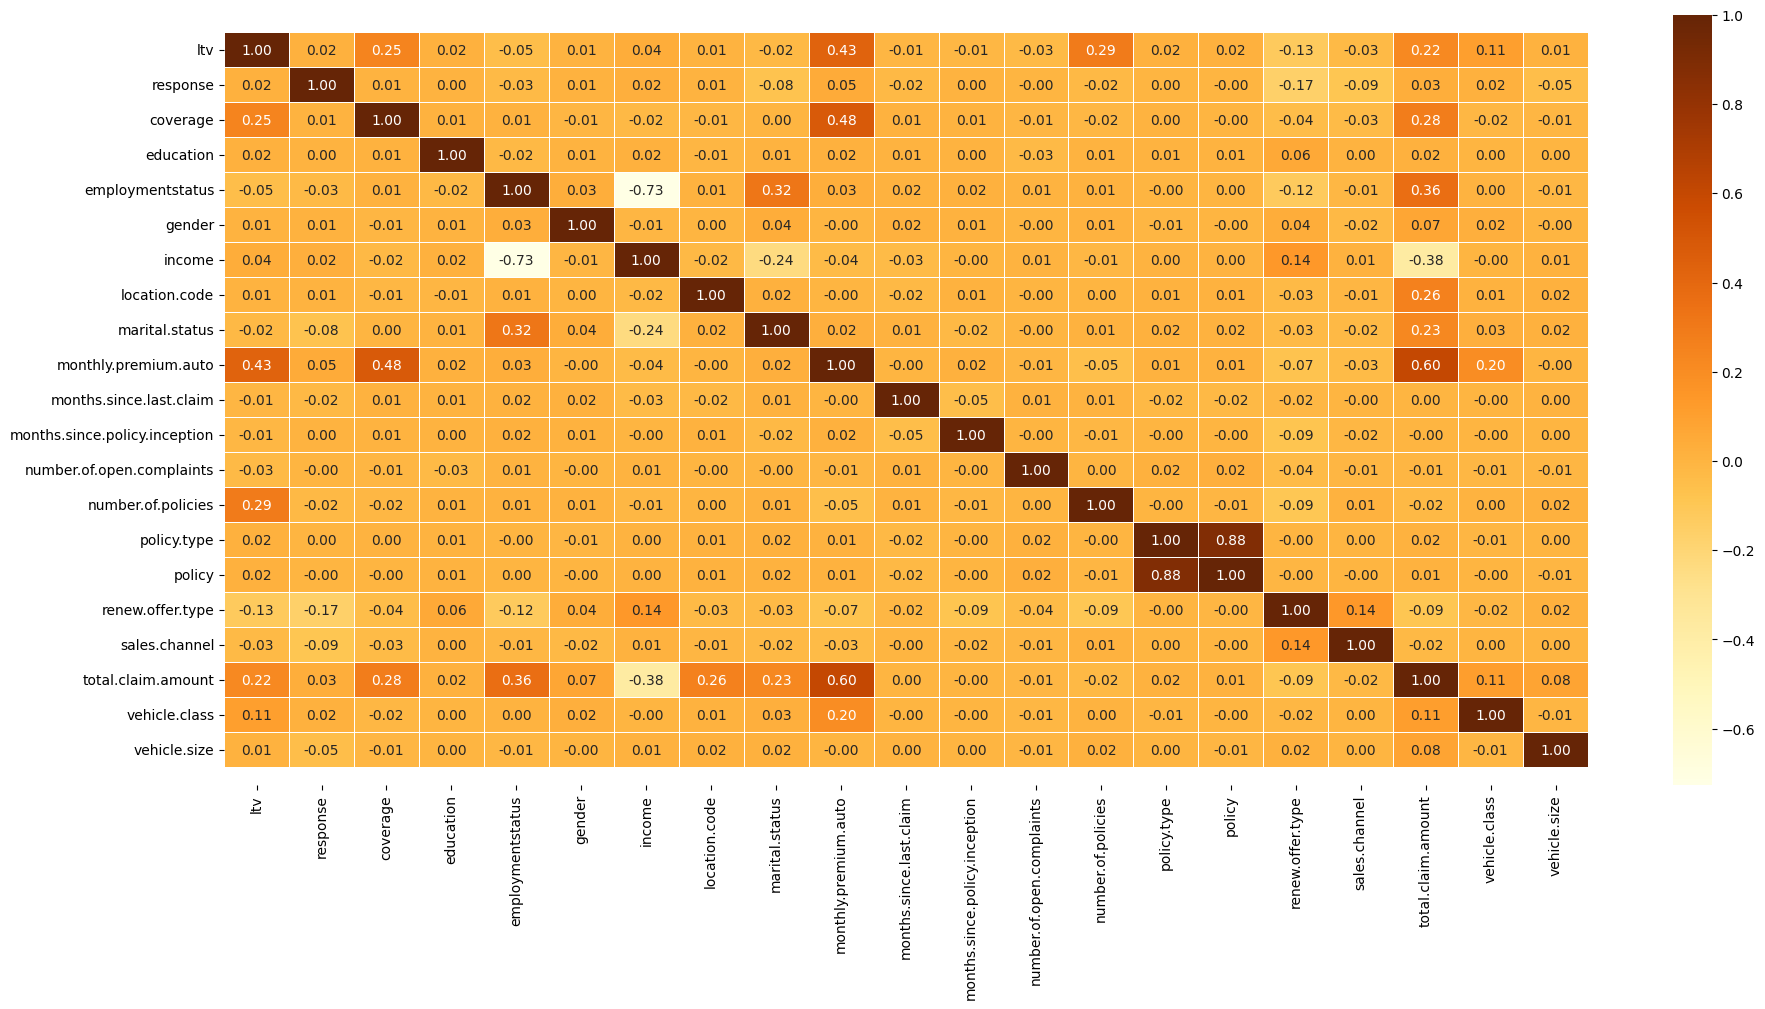

In [20]:
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(22, 10))
ax = sns.heatmap(corr_matrix,annot=True,linewidths=0.5,fmt=".2f",cmap="YlOrBr");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [47]:
X = data[['monthly.premium.auto','number.of.policies','coverage','total.claim.amount','vehicle.class','renew.offer.type']]
# X = data[['monthly.premium.auto','number.of.policies','coverage','vehicle.class','renew.offer.type']]
y = data['ltv']

In [48]:
normal_X = np.log(X+1)
normal_y = np.log(y)

In [49]:
scalar = preprocessing.StandardScaler() 
  
scalar.fit(normal_X) 
scaled_data = scalar.transform(normal_X)

scaled_data = pd.DataFrame(data=scaled_data, columns=['monthly.premium.auto','number.of.policies','coverage','total.claim.amount','vehicle.class','renew.offer.type'])
# scaled_data = pd.DataFrame(data=scaled_data, columns=['monthly.premium.auto','number.of.policies','coverage','vehicle.class','renew.offer.type'])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data , normal_y, test_size=0.3, random_state=200)

In [51]:
# Linear Regression

In [52]:
liner_regression = LinearRegression()

liner_regression.fit(X_train,y_train)
print('Training accuracy =',liner_regression.fit(X_train,y_train).score(X_train,y_train)*100,'\n')

liner_regression_pred_res = liner_regression.predict(X_test)
liner_regression_pred_all_data_res = liner_regression.predict(X)

liner_regression_r2 = r2_score(y_test, liner_regression_pred_res)
liner_regression_mape = mean_absolute_percentage_error(y_test, liner_regression_pred_res)

print(f'R2 score: {round(liner_regression_r2,4)}')
print(f'MAPE: {round(liner_regression_mape,4)}')
print('MAE:', round(mean_absolute_error(y_test, liner_regression_pred_res),4))
print('MSE:', round(mean_squared_error(y_test, liner_regression_pred_res), 4))
print('RMSE:', round(np.sqrt(mean_squared_error(y_test, liner_regression_pred_res)),4), '\n')

print(f'weights: {liner_regression.intercept_, *liner_regression.coef_}')
print(f'prediction: {liner_regression_pred_res}')

Training accuracy = 47.56282756936686 

R2 score: 0.503
MAPE: 0.031
MAE: 0.2677
MSE: 0.115
RMSE: 0.3391 

weights: (8.584937795402992, 0.23270963473001774, 0.2532559797963212, 0.00963595185797478, -0.020364683067905523, 0.0033897534082055142, -0.016615103314929224)
prediction: [8.28136663 8.29707695 8.26597672 ... 8.37460985 8.14461121 8.20661455]


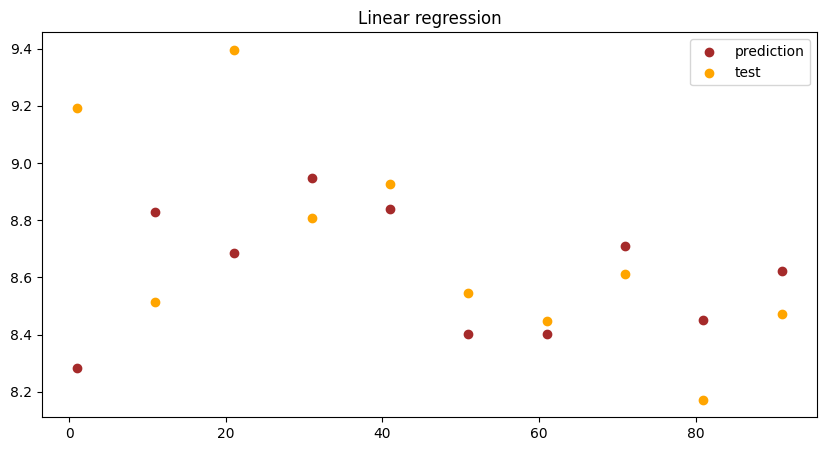

In [53]:
fig=plt.figure(figsize=(10,5))
plt.title('Linear regression')
plt.scatter(np.arange(1,100,10),liner_regression_pred_res[0:100:10],color='brown')
plt.scatter(np.arange(1,100,10),y_test[0:100:10],color='orange')
plt.legend(['prediction','test'])

In [54]:
# Polinomial Regression

In [55]:
poly_features = PolynomialFeatures(degree=5, include_bias=True)

X_poly = poly_features.fit_transform(normal_X)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, normal_y, test_size=0.3, random_state=200)

In [56]:
polynomial_regression = LinearRegression()

polynomial_regression.fit(X_poly_train, y_poly_train)

polynomial_regression_pred_res = polynomial_regression.predict(X_poly_test)
polynomial_regression_pred_all_data_res = polynomial_regression.predict(X_poly)

polynomial_regression_r2 = r2_score(y_poly_test, polynomial_regression_pred_res)
polynomial_regression_mape = mean_absolute_percentage_error(y_poly_test, polynomial_regression_pred_res)

In [57]:
print('Training accuracy =',polynomial_regression.fit(X_poly_train,y_poly_train).score(X_poly_train,y_poly_train)*100, '\n')
print(f'R2 score: {polynomial_regression_r2}')
print(f'MAPE: {polynomial_regression_mape}')
print('MAE:', mean_absolute_error(y_poly_test, polynomial_regression_pred_res))
print('MSE:', mean_squared_error(y_poly_test, polynomial_regression_pred_res))
print('RMSE:',np.sqrt(mean_squared_error(y_poly_test, polynomial_regression_pred_res)), '\n')

Training accuracy = 97.90994868938454 

R2 score: 0.973343579033567
MAPE: 0.0059346925076198065
MAE: 0.051282696807408226
MSE: 0.006166016919214112
RMSE: 0.07852398945044828 



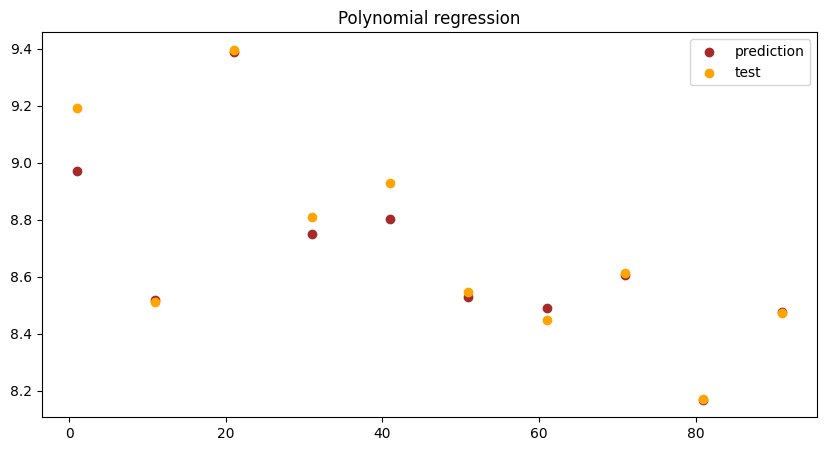

In [58]:
fig=plt.figure(figsize=(10,5))
plt.title('Polynomial regression')
plt.scatter(np.arange(1,100,10),polynomial_regression_pred_res[0:100:10],color='brown')
plt.scatter(np.arange(1,100,10),y_test[0:100:10],color='orange')
plt.legend(['prediction','test'])

In [59]:
# Ridge Regression

In [60]:
ridge_regression = Ridge()
ridge_regression.fit(X_train, y_train);

In [61]:
ridge_regression_pred_res = ridge_regression.predict(X_test)
ridge_regression_pred_all_data_res = ridge_regression.predict(X)

ridge_regression_r2 = r2_score(y_test, ridge_regression_pred_res)
ridge_regression_mape = mean_absolute_percentage_error(y_test, ridge_regression_pred_res)

In [62]:
print('Training accuracy =',ridge_regression.fit(X_train,y_train).score(X_train,y_train)*100, '\n')
print(f'R2 score: {ridge_regression_r2}')
print(f'MAPE: {ridge_regression_mape}')
print('MAE:', mean_absolute_error(y_test, ridge_regression_pred_res))
print('MSE:', mean_squared_error(y_test, ridge_regression_pred_res))
print('RMSE:',np.sqrt(mean_squared_error(y_test, ridge_regression_pred_res)), '\n')

Training accuracy = 47.56282525907306 

R2 score: 0.5029664704306636
MAPE: 0.030975661178819967
MAE: 0.267742590315169
MSE: 0.11497106669347978
RMSE: 0.3390738366395729 



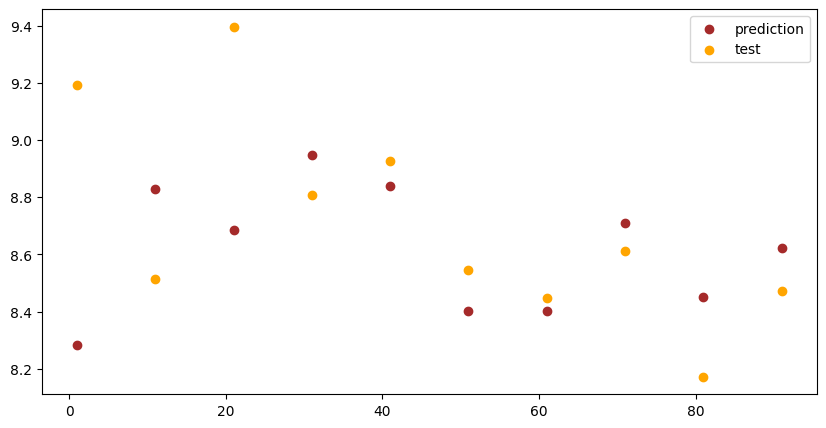

In [63]:
fig=plt.figure(figsize=(10,5))
plt.scatter(np.arange(1,100,10),ridge_regression_pred_res[0:100:10],color='brown')
plt.scatter(np.arange(1,100,10),y_test[0:100:10],color='orange')
plt.legend(['prediction','test'])

In [64]:
# Gradient Boosting

In [65]:
gradient_bosting = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping_rounds = 5);
gradient_bosting.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False);

In [66]:
gradient_bosting_pred_res = gradient_bosting.predict(X_test)
gradient_bosting_pred_all_data_res = gradient_bosting.predict(X)

gradient_bosting_r2 = r2_score(y_test, gradient_bosting_pred_res)
gradient_bosting_mape = mean_absolute_percentage_error(y_test, gradient_bosting_pred_res)

print('Training accuracy =', gradient_bosting.score(X_train, y_train)*100)
print('Prediction accuracy =', explained_variance_score(y_test, gradient_bosting_pred_res)*100, '\n')

print(f'R2 score: {gradient_bosting_r2}')
print(f'MAPE: {gradient_bosting_mape}')
print('MAE:', mean_absolute_error(y_test, gradient_bosting_pred_res))
print('MSE:', mean_squared_error(y_test, gradient_bosting_pred_res))
print('RMSE:',np.sqrt(mean_squared_error(y_test, gradient_bosting_pred_res)))

Training accuracy = 99.49617259155265
Prediction accuracy = 97.4920587739387 

R2 score: 0.9749204865198033
MAPE: 0.005407890288952782
MAE: 0.04657033419339927
MSE: 0.005801255338789939
RMSE: 0.07616597231566034


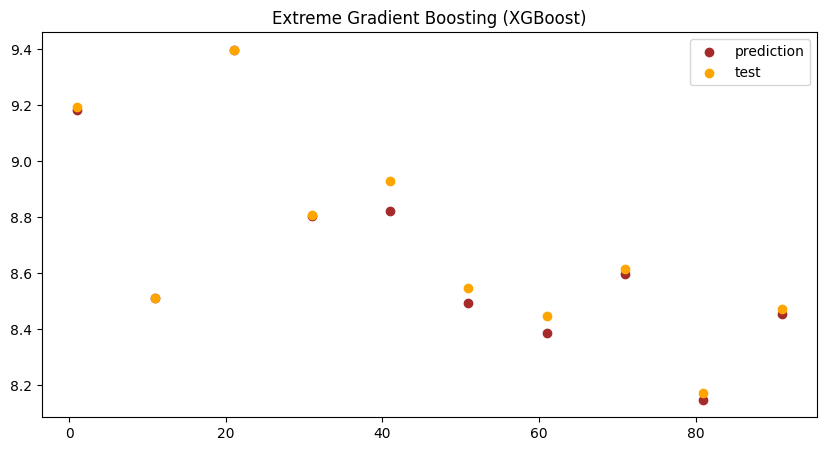

In [93]:
fig=plt.figure(figsize=(10,5))
plt.title('Extreme Gradient Boosting (XGBoost)')
plt.scatter(np.arange(1,100,10),gradient_bosting_pred_res[0:100:10],color='brown')
plt.scatter(np.arange(1,100,10),y_test[0:100:10],color='orange')
plt.legend(['prediction','test'])

In [84]:
# Category Gradient Boosting

In [85]:
category_gradient_bosting = CatBoostRegressor(verbose=0, n_estimators=100)
category_gradient_bosting.fit(X_train, y_train)

In [95]:
category_gradient_bosting_pred_res = category_gradient_bosting.predict(X_test)
category_gradient_bosting_pred_all_data_res = category_gradient_bosting.predict(X)

category_gradient_bosting_r2 = r2_score(y_test, category_gradient_bosting_pred_res)
category_gradient_bosting_mape = mean_absolute_percentage_error(y_test, category_gradient_bosting_pred_res)

print('Training accuracy =', category_gradient_bosting.score(X_train, y_train)*100)
print('Prediction accuracy =', explained_variance_score(y_test, category_gradient_bosting_pred_res)*100, '\n')

print(f'R2 score: {category_gradient_bosting_r2}')
print(f'MAPE: {category_gradient_bosting_mape}')
print('MAE:', mean_absolute_error(y_test, category_gradient_bosting_pred_res))
print('MSE:', mean_squared_error(y_test, category_gradient_bosting_pred_res))
print('RMSE:',np.sqrt(mean_squared_error(y_test, category_gradient_bosting_pred_res)))

Training accuracy = 98.37550728989295
Prediction accuracy = 97.85528609649454 

R2 score: 0.978552609779361
MAPE: 0.0052808700040936195
MAE: 0.045552614205581994
MSE: 0.0049610925315134
RMSE: 0.07043502347208667


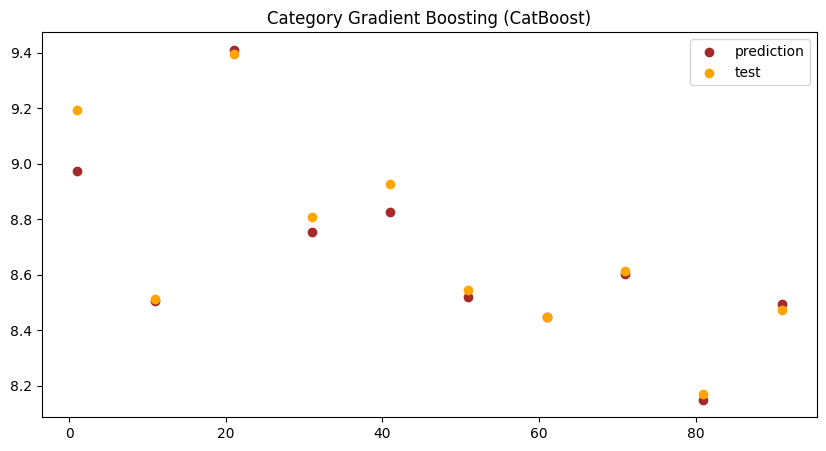

In [94]:
fig=plt.figure(figsize=(10,5))
plt.title('Category Gradient Boosting (CatBoost)')
plt.scatter(np.arange(1,100,10),category_gradient_bosting_pred_res[0:100:10],color='brown')
plt.scatter(np.arange(1,100,10),y_test[0:100:10],color='orange')
plt.legend(['prediction','test'])